In [3]:
%matplotlib notebook
from pathlib import Path
import cartopy.crs as ccrs
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import stats
import statsmodels.api as sm
import datetime 
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import math
import statistics
from numpy import*
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime

In [4]:
file=Path(r"D:\Datasets\XTRACK\ESACCI-SEALEVEL-L3-SLA-N_INDIAN-MERGED-20200113-JA-014-fv01.1.nc")
ds=xr.open_dataset(file,decode_times=False)

In [71]:
def select_point(ds,point):
    ''' select a point in a track and return a dict with needed parameters'''
    #ref=pd.Timestamp(1950,1,1)
    output={}
    print(f"extract point #{point} on track {ds.pass_number}")
    output["dist"]=ds.dist_to_coast_gshhs[point].values/1000.
    output['pt']=point
    output["location"]=[ds.lon[point].values,ds.lat[point].values]
    #time = pd.to_datetime(ds.time[point,:], unit='D', origin=ref)
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    output["ts"]=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    output["valid"] = (1-(output['ts'].isna().sum().values[0] / len(output['ts'])))*100.
    output["trend"],intercept = trend_ols(sla.values,ds.time[point,:].values)
    output['trend_rate']=output["trend"]*1000*365
    output['flagged']=sigma_mask(output['ts'])
    return output

def sigma_mask(df,n=2):
    '''''''removing outliers'''
    sigma = df.std()
    mask = (df >- n*sigma) & (df < n*sigma)
    df_masked=df[mask.values]
    return df_masked

def flagged_trend(ds,point):
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    df=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    df_masked=sigma_mask(df,n=2)
    slope,intercept=trend_ols(df_masked.values,df_masked.index.values)
    trend_rate=slope*1000*365
    print ('trend rate is :',(trend_rate),'mm/yr' )


def plot_point(ds,point):
    '''ploting points without outliers'''
    ref=pd.Timestamp(1950,1,1)
    output=select_point(ds,point)
    title=f"Point No: {point} - Distance to Coast: {output['dist']:.2f} km-{output['valid']:.2f}%"
    df=output['ts']
    df_flagged=output['flagged']
    time=pd.to_datetime(output['ts'].index, unit='D', origin=ref)
    time_flagged=pd.to_datetime(output['flagged'].index, unit='D', origin=ref)

    #plots
    fig,ax=plt.subplots()
    ax.scatter(time,df.values,color='red')
    ax.scatter(time_flagged,df_flagged.values,color='black')
    slope,intercept=trend_ols(df_flagged.values,df_flagged.index.values)
    y_fit=  slope*df_flagged.index.values+intercept
    ax.plot(time_flagged,y_fit,linewidth=2.,c='red')
    ax.set_title(title)
    return ax

def trend_ols(y,x,summary=False):
    ''' '''
    model=sm.OLS(y,sm.add_constant(x),missing='drop')
    results=model.fit()
    intercept,slope = results.params
    y_fit=  slope*x+intercept
    if summary :
        print(results.summary())
    else :
        pass
        #print(f"the slope is {slope}")
        #print ('trend rate is :',(trend_rate),'mm/yr' )
    return slope,intercept

def map_selected_point(ds,point,extent=None):
    dl=1.
    if extent is None :
        extent = [ds.lon.min()-dl, ds.lon.max()+dl, ds.lat.min()-dl, ds.lat.max()+dl]
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines(resolution='10m') 
    ax.gridlines(draw_labels=True)
    ax.scatter(ds.lon.values,ds.lat.values,color='black',marker='.')
    ax.scatter(ds.lon[point].values,ds.lat[point].values,color='red',marker='o',zorder=1)
    return ax

def dt_to_dec(dt):
    """Convert a datetime to decimal year."""
    year_start = datetime(dt.year, 1, 1)
    year_end = year_start.replace(year=dt.year+1)
    return dt.year + ((dt - year_start).total_seconds() /  # seconds so far
        float((year_end - year_start).total_seconds()))  # seconds in year

extract point #4010 on track 014


<IPython.core.display.Javascript object>


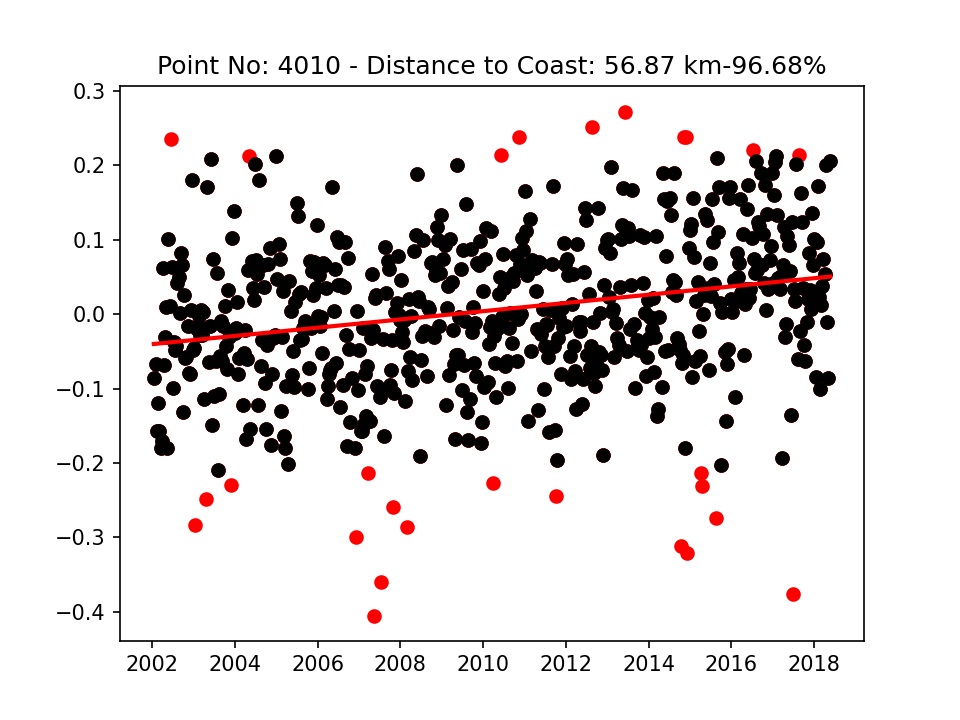

In [74]:
a=plot_point(ds,4010)

In [66]:
d['trend']

(1.5352887555262885e-05, -0.33700625674302453)

In [55]:
a,b=trend_ols(df_flagged.index.values,df_flagged.index.values)

In [57]:
b

3.410605131648481e-13

<IPython.core.display.Javascript object>


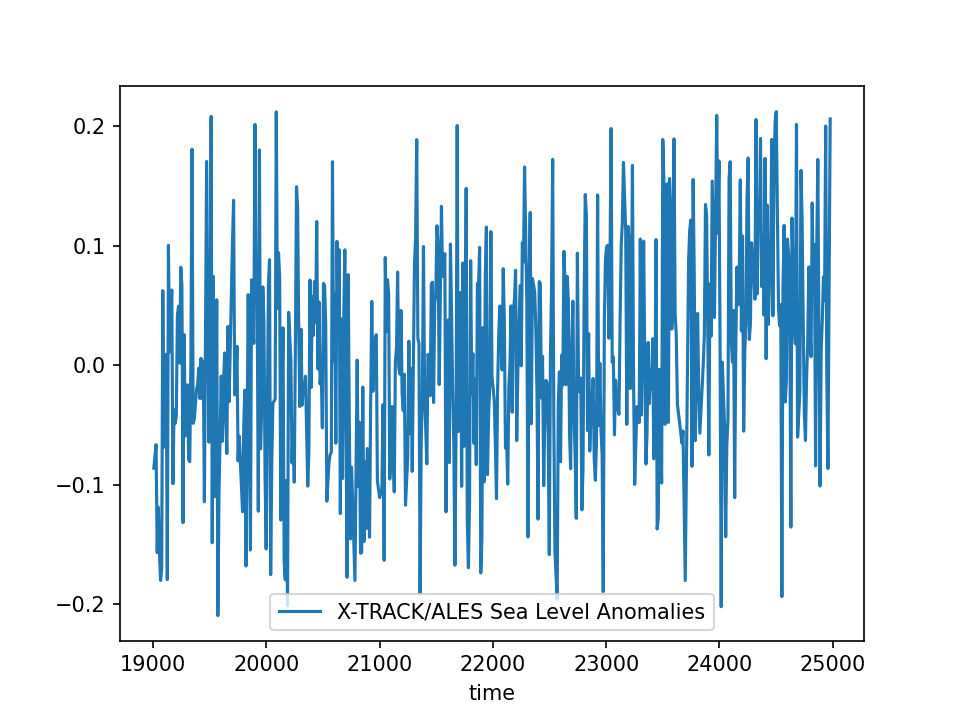

In [19]:
d['flagged'].plot()

In [70]:
slope=trend_ols(df_masked.values,df_masked.index.values,summary=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     49.61
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           5.58e-12
Time:                        15:41:13   Log-Likelihood:                 566.42
No. Observations:                 556   AIC:                            -1129.
Df Residuals:                     554   BIC:                            -1120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3284      0.048     -6.908      0.0

<IPython.core.display.Javascript object>


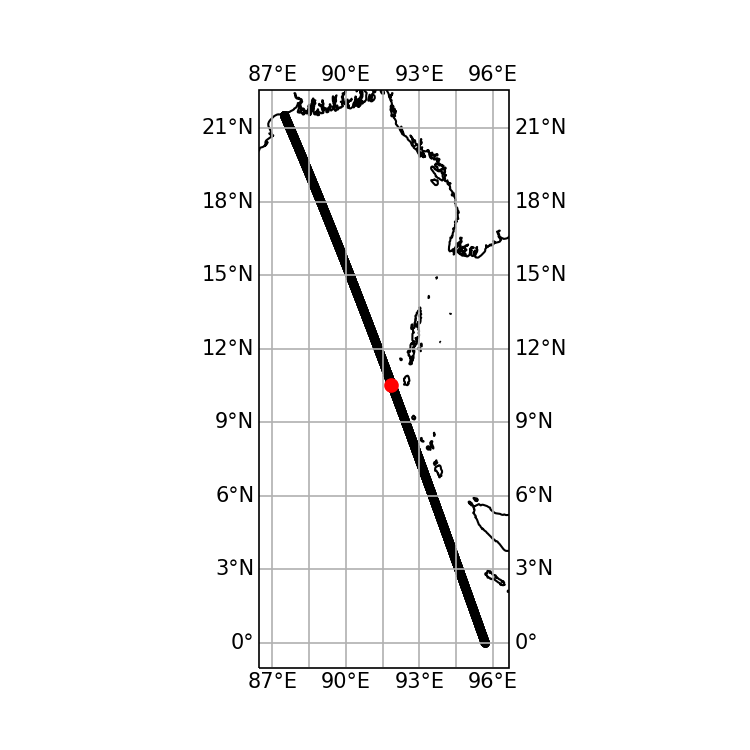

In [75]:
map_selected_point(ds,4010)